##Estimación de demanda de IES

##0. Instalación y carga de librerías

In [ ]:
!pip install catboost --quiet

     |████████████████████████████████| 67.3MB 65kB/s 


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
import multiprocessing
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings("ignore")

##1. Carga y formateo de archivo base

In [ ]:
files = files.upload()

Saving Consolidado_final_v2.xlsx to Consolidado_final_v2.xlsx


In [ ]:
archivo = pd.read_excel('Consolidado_final_v2.xlsx')
archivo.head(3)

,Año,codigo,NOMBRE IES,NOMBRE CARRERA,TIPO INST 2,TIPO INST 3,REGION SEDE,COMUNA SEDE,AREA CARRERA GENERICA,AREA CONOCIMIENTO,n_24,n_25,n_26,n_Total,m_24,m_25,vacantes_1S,demanda_1,sobrecupos,Convocados,demanda_2,Muestra_2021,auxiliar_muestra,llena_vacante,llena_vacante2,Deficit,gratuidad,duracion,arancel_2021,arancel_anual,matricula_2021,PCT_NOTAS,PCT_RANKING,PCT_LENG,PCT_MATE,PCT_COLEGIO,RM,V,VIII,ingreso_1,ingreso_2,ingreso_3,ingreso_4,ingreso_5,emplea_1,emplea_2,acreditacion
0,2019,11001,UNIVERSIDAD DE CHILE,ARQUITECTURA,Universidades CRUCH,Universidades Estatales CRUCH,REGION METROPOLITANA,SANTIAGO,Arquitectura,Arte y Arquitectura,311,277,451,1039,647.6,600.0,280,3.710714,30.0,310.0,3.351613,NO,NO,SI,1,0,1,12.0,4472200.0,4174900.0,149000.0,20,20,20,30,40,1,0,0,795871.710423,941552.758398,1.071521e+06,1.221897e+06,1.321313e+06,0.741593,0.817106,7
1,2019,11003,UNIVERSIDAD DE CHILE,ACTUACION TEATRAL,Universidades CRUCH,Universidades Estatales CRUCH,REGION METROPOLITANA,SANTIAGO,Actuación y Teatro,Arte y Arquitectura,23,21,15,59,687.9,612.8,23,2.565217,0.0,23.0,2.565217,NO,NO,SI,1,0,1,10.0,3756700.0,3273900.0,149000.0,10,20,30,15,30,1,0,0,576797.728865,626869.675583,7.334167e+05,8.081382e+05,8.758894e+05,0.273481,0.348315,7
2,2019,11004,UNIVERSIDAD DE CHILE,DISEÑO TEATRAL,Universidades CRUCH,Universidades Estatales CRUCH,REGION METROPOLITANA,SANTIAGO,Diseño Teatral,Arte y Arquitectura,28,7,33,68,606.5,600.2,23,2.956522,5.0,28.0,2.428571,NO,NO,SI,1,0,1,10.0,3756700.0,3273900.0,149000.0,10,20,25,20,30,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [ ]:
archivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542 entries, 0 to 5541
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año                    5542 non-null   int64  
 1   codigo                 5542 non-null   int64  
 2   NOMBRE IES             5542 non-null   object 
 3   NOMBRE CARRERA         5542 non-null   object 
 4   TIPO INST 2            5542 non-null   object 
 5   TIPO INST 3            5542 non-null   object 
 6   REGION SEDE            5542 non-null   object 
 7   COMUNA SEDE            5542 non-null   object 
 8   AREA CARRERA GENERICA  5542 non-null   object 
 9   AREA CONOCIMIENTO      5542 non-null   object 
 10  n_24                   5542 non-null   int64  
 11  n_25                   5542 non-null   int64  
 12  n_26                   5542 non-null   int64  
 13  n_Total                5542 non-null   int64  
 14  m_24                   5537 non-null   float64
 15  m_25

In [ ]:
archivo['Año'] = archivo['Año'].astype('category')
archivo['AREA CONOCIMIENTO'] = archivo['AREA CONOCIMIENTO'].astype('category')

##2. Elección de variables y construcción de Dataframes de entrenamiento y prueba

Las variables a utilizar para predecir si se llena una vacante serán:

- Año: Año del proceso.
- AREA CONOCIMIENTO: Área de conocimiento de la carrera según Mineduc.
- acreditacion: Años de acreditación de la universidad.
- gratuidad: Si la carrera tuvo gratuidad en el año.
- vacantes: Vacantes informadas para la carrera **[Nuevo]**
- duracion: duración en semestres de la carrera.
- PCT_COLEGIO: Suma de las ponderaciones de NEM y ranking de notas que exige la carrera.
- matricula_2021: Valor de la matrícula 2021 de la carrera (info SIES).
- RM: Si la carrera es de la región metropolitana.
- ingreso_3: Ingreso bruto al tercer año de la carrera (info SIES).
- emplea_1: Tasa de empleabilidad al primer año de la carrera (info SIES).

In [ ]:
#features = ['Año','AREA CONOCIMIENTO','acreditacion','gratuidad', 'duracion','PCT_COLEGIO','matricula_2021','RM','ingreso_3','emplea_1']
features = ['Año','AREA CONOCIMIENTO','acreditacion','gratuidad', 'vacantes_1S','duracion','PCT_COLEGIO','matricula_2021','RM','V','VIII','ingreso_3','emplea_1']

In [ ]:
numeric = archivo[features].select_dtypes(include=['float64','int64','int32']).columns.to_list()

imputer = IterativeImputer()
data = imputer.fit_transform(archivo[numeric])
nuevo_data = pd.DataFrame(data, columns=numeric)

archivo['duracion'] = nuevo_data['duracion']
archivo['matricula_2021'] = nuevo_data['matricula_2021']
archivo['ingreso_3'] = nuevo_data['ingreso_3']
archivo['emplea_1'] = nuevo_data['emplea_1']

In [ ]:
archivo[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542 entries, 0 to 5541
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Año                5542 non-null   category
 1   AREA CONOCIMIENTO  5542 non-null   category
 2   acreditacion       5542 non-null   int64   
 3   gratuidad          5542 non-null   int64   
 4   vacantes_1S        5542 non-null   int64   
 5   duracion           5542 non-null   float64 
 6   PCT_COLEGIO        5542 non-null   int64   
 7   matricula_2021     5542 non-null   float64 
 8   RM                 5542 non-null   int64   
 9   V                  5542 non-null   int64   
 10  VIII               5542 non-null   int64   
 11  ingreso_3          5542 non-null   float64 
 12  emplea_1           5542 non-null   float64 
dtypes: category(2), float64(4), int64(7)
memory usage: 487.7 KB


La variable target Y es la demanda, que son los postulantes por vacantes ofrecidas.

In [ ]:
X = archivo[features]
y = archivo['demanda_1']

Se separa el archivo en dos: uno para entrenar el modelo y en otra para probarlo. La muestra de prueba será del 14% de la muestra total y con ello se tendrán 4766 observaciones para entrenar el modelo y 776 para probarlo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.14, random_state=0)

In [ ]:
X_train.shape, X_test.shape

((4766, 13), (776, 13))

In [ ]:
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64','int32']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas, se estandarizan las numéricas.
preprocessor = ColumnTransformer(
                    [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat,numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels) #pd.DataFrame.sparse.from_spmatrix
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4766 entries, 0 to 4765
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Año_2019                                     4766 non-null   float64
 1   Año_2020                                     4766 non-null   float64
 2   Año_2021                                     4766 non-null   float64
 3   AREA CONOCIMIENTO_Administración y Comercio  4766 non-null   float64
 4   AREA CONOCIMIENTO_Agropecuaria               4766 non-null   float64
 5   AREA CONOCIMIENTO_Arte y Arquitectura        4766 non-null   float64
 6   AREA CONOCIMIENTO_Ciencias Básicas           4766 non-null   float64
 7   AREA CONOCIMIENTO_Ciencias Sociales          4766 non-null   float64
 8   AREA CONOCIMIENTO_Derecho                    4766 non-null   float64
 9   AREA CONOCIMIENTO_Educación                  4766 non-null   float64
 10  

##3. Entrenamiento de modelos

In [ ]:
score_train =[]
score_test = []
MSE_train = [] #mean squared error
MSE_test = []

names = ['CatBoost', 'XGBoost','LightGBM', 'Decision Tree', 'Random Forest', 'Support Vector Machine',
         'AdaBoost', 'Gradient Boosting', 'K Neighbors', 'Extra Trees', 'Lineal Regression', 'Neural Network']

models = [cb.CatBoostRegressor(silent=True), xgb.XGBRegressor(),lgb.LGBMRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), SVR(), AdaBoostRegressor(), GradientBoostingRegressor(), KNeighborsRegressor(), ExtraTreesRegressor(), LinearRegression(),
          MLPRegressor()]


for model in zip(names, models):
  model[1].fit(X_train_prep, y_train)
  score_train.append(model[1].score(X_train_prep,y_train))
  score_test.append(model[1].score(X_test_prep,y_test))

  MSE_train.append(mean_squared_error(y_train, model[1].predict(X_train_prep)))
  MSE_test.append(mean_squared_error(y_test, model[1].predict(X_test_prep)))

pd.DataFrame({'Modelo':names,
              'R2 Train':score_train,
              'R2 Test': score_test,
              'MSE Train': MSE_train,
              'MSE Test': MSE_test}).sort_values('R2 Test', ascending=False)

[20:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Modelo,R2 Train,R2 Test,MSE Train,MSE Test
0,CatBoost,0.891482,0.778100,1.912587,3.267301
4,Random Forest,0.964697,0.745201,0.622204,3.751714
9,Extra Trees,0.995011,0.741006,0.087932,3.813476
2,LightGBM,0.845473,0.701353,2.723485,4.397328
3,Decision Tree,0.995011,0.620368,0.087932,5.589771
7,Gradient Boosting,0.646524,0.580703,6.229891,6.173801
1,XGBoost,0.637818,0.573911,6.383327,6.273809
11,Neural Network,0.657071,0.533453,6.044005,6.869517
8,K Neighbors,0.678357,0.477507,5.668838,7.693283
5,Support Vector Machine,0.438997,0.397740,9.887475,8.867791


##4. Validación de modelo elegido

En adelante se trabajará con Catboost por tener mejor rendimiento en la muestra de prueba con alrededor de 72% de score (análogamente alcanzando el mínimo MSE).

In [ ]:
model = cb.CatBoostRegressor(silent=True)
model.fit(X_train_prep,y_train)

y_pred = model.predict(X_test_prep)

model.score(X_test_prep,y_test)

0.7780996924015794

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train_prep.columns,
                             'importancia': model.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

,predictor,importancia
5,AREA CONOCIMIENTO_Arte y Arquitectura,14.719884
3,AREA CONOCIMIENTO_Administración y Comercio,13.594693
10,AREA CONOCIMIENTO_Humanidades,13.432339
22,ingreso_3,10.556772
9,AREA CONOCIMIENTO_Educación,9.904208
2,Año_2021,8.668480
0,Año_2019,6.707161
6,AREA CONOCIMIENTO_Ciencias Básicas,3.990373
1,Año_2020,3.708080
4,AREA CONOCIMIENTO_Agropecuaria,3.507233


**Gráfico de ajuste del modelo**

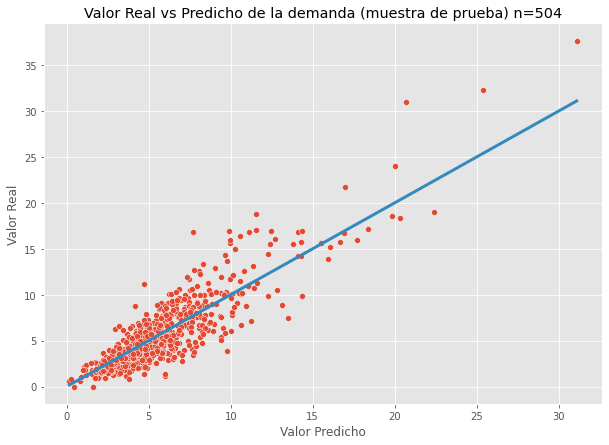

In [ ]:
plt.figure(figsize=(10,7))
sb.scatterplot(x=y_pred,y=y_test)
sb.lineplot(x=y_pred, y=y_pred, color='#348ABD', linewidth=3)

plt.title('Valor Real vs Predicho de la demanda (muestra de prueba) n=504')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real');

#Ejemplos

Ejemplo de carrera de salud de 10 semestres sin gratuidad. El modelo entrega 9,4 postulantes por vacantes.

In [ ]:
prueba = pd.DataFrame({'Año': [2021],
                       'AREA CONOCIMIENTO':['Salud'],
                       'acreditacion':[4],
                       'gratuidad':[0],
                       'vacantes_1S':[60], #60 es como el promedio del ultimo año
                       'duracion':[10],
                       'PCT_COLEGIO':[50],
                       'matricula_2021':[170000],
                       'RM':[1],
                       'V':[0],
                       'VIII':[0],
                       'ingreso_3':[1255000],
                       'emplea_1':[0.665]})

X_prueba_prep  = preprocessor.transform(prueba)
model.predict(X_prueba_prep)[0]

9.444961750852489

Ejemplo de carrera de salud de 5 semestres. El modelo entrega 5,6 postulantes por vacantes.

In [ ]:
prueba2 = pd.DataFrame({'Año': [2021],
                       'AREA CONOCIMIENTO':['Salud'],
                      'acreditacion':[4], #4 años de acreditacion
                       'gratuidad':[0],
                       'vacantes_1S':[60],
                       'duracion':[5],
                       'PCT_COLEGIO':[50],
                       'matricula_2021':[200000],
                       'RM':[1],
                        'V':[0],
                        'VIII':[0],
                       'ingreso_3':[544000],
                       'emplea_1':[0.44]})

X_prueba2_prep  = preprocessor.transform(prueba2)
model.predict(X_prueba2_prep)[0]

5.673399448773788

In [ ]:
from google.colab import files
carga = files.upload()

Saving ejemplo_UDLA_reg.xlsx to ejemplo_UDLA_reg.xlsx


In [ ]:
udla = pd.read_excel('ejemplo_UDLA_reg.xlsx')
udla.head(3) #ejemplo de 3 observaciones

,Año,NOMBRE CARRERA,AREA CARRERA GENERICA,AREA CONOCIMIENTO,gratuidad,duracion,PCT_COLEGIO,matricula_2021,RM,V,VIII,ingreso_3,emplea_1,acreditacion,vacantes_1S
0,2021,INGENIERIA DE EJECUCION EN ADMINISTRACION DE E...,Administración de Empresas e Ing. Asociadas,Administración y Comercio,0,8,40,170000,1,0,0,1.129011e+06,0.772107,4,60
1,2021,CONSTRUCCION CIVIL,Construcción Civil,Tecnología,0,9,40,170000,1,0,0,1.353673e+06,0.860196,4,60
2,2021,INGENIERIA DE EJECUCION EN INFORMATICA,Ingeniería en Computación e Informática,Tecnología,0,8,40,160000,1,0,0,1.243573e+06,0.828190,4,60


In [ ]:
udla_data = preprocessor.transform(udla[features])

pronostico_demanda = model.predict(udla_data)

udla['pronostico'] = pronostico_demanda

udla.to_excel('udla_predict.xlsx')

Ejemplo de demanda de carreras UDLA con y sin gratuidad en región metropolitana:

In [ ]:
udla.pivot_table(index='NOMBRE CARRERA', columns=['gratuidad'],  values='pronostico', aggfunc=np.mean)

gratuidad,0,1
NOMBRE CARRERA,,
CONSTRUCCION CIVIL,3.672922,5.157276
ENFERMERIA,9.087094,11.142726
FONOAUDIOLOGIA,2.264535,3.238555
HOTELERIA Y TURISMO,2.478486,3.344382
INGENIERIA AMBIENTAL,2.133514,3.170628
INGENIERIA CIVIL EN COMPUTACION E INFORMATICA,6.412299,7.655751
INGENIERIA CIVIL INDUSTRIAL,3.920327,5.118493
INGENIERIA COMERCIAL,4.627151,5.860275
INGENIERIA DE EJECUCION EN ADMINISTRACION DE EMPRESAS,2.761650,3.833905


In [ ]:
demanda_k = []

for k in np.arange(20, 71, step=5):
  prueba_k = pd.DataFrame({'Año': [2021],
                       'AREA CONOCIMIENTO':['Tecnología'],
                       'acreditacion':[4],
                       'gratuidad':[0],
                       'vacantes_1S':[40],
                       'duracion':[10],
                       'PCT_COLEGIO':[k],
                       'matricula_2021':[160000],
                       'RM':[1],
                       'V':[0],
                       'VIII':[0],
                       'ingreso_3':[1497727],
                       'emplea_1':[0.894]})

  X_prueba_k_prep  = preprocessor.transform(prueba_k)
  demanda_k.append(model.predict(X_prueba_k_prep)[0])

listado = pd.DataFrame({'PCT_COLEGIO': np.arange(20, 71, step=5),
                        'demanda': np.array(demanda_k)}).sort_values('demanda', ascending=False)

listado.head()

,PCT_COLEGIO,demanda
0,20,7.775158
1,25,7.762026
2,30,7.512047
3,35,7.314829
4,40,7.023533


In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(np.arange(20, 71, step=5), demanda_k)
plt.xticks(np.arange(20, 71, step=5))
plt.xlabel('% PCT_COLEGIO')
plt.ylabel('Demanda')
plt.title('Demanda para Ing. Civil Informática (sin gratuidad)');

**UDLA diurno - en construcción**

In [ ]:
from google.colab import files
carga = files.upload()

Saving Oferta diurno profesional_NA.xlsx to Oferta diurno profesional_NA.xlsx


In [ ]:
udla_diurno = pd.read_excel('Oferta diurno profesional_NA.xlsx')

udla_imputer = imputer.transform(udla_diurno[numeric])
udla_imputer = pd.DataFrame(udla_imputer, columns=numeric)

udla_diurno['ingreso_3'] = udla_imputer['ingreso_3']
udla_diurno['emplea_1'] = udla_imputer['emplea_1']

#udla_diurno[features] = udla_diurno
#udla_diurno.isnull().sum()

In [ ]:
demanda_k = []
indice = []
ponderacion = []

for i in udla_diurno.index:
  for k in np.arange(20,71, step=5):
    udla_diurno['PCT_COLEGIO'] = k
    X_prueba_k_prep  = preprocessor.transform(udla_diurno.iloc[i:i+1])
    demanda_k.append(model.predict(X_prueba_k_prep)[0])
    indice.append(i)
    ponderacion.append(k)

salida = pd.DataFrame({'indice':indice, 'ponderacion':ponderacion, 'demanda':demanda_k})

In [ ]:
tabla = salida.pivot_table(index=['indice'], columns=['ponderacion'], values='demanda', aggfunc='max')
tabla

ponderacion,20,25,30,35,40,45,50,55,60,65,70
indice,,,,,,,,,,,
0,5.255580,5.268716,5.291656,5.477106,5.630178,5.399740,5.143390,5.153879,5.049472,5.049472,5.014023
1,5.648021,5.716388,5.693362,5.660137,5.740110,5.527248,5.311059,5.321548,5.212468,5.212468,5.177019
2,4.982363,5.005014,5.046046,5.376651,5.555083,5.306421,5.126921,5.082861,4.926699,4.926699,4.891250
3,4.930409,4.998775,5.025288,4.989526,5.153968,4.937637,4.765768,4.776258,4.637884,4.637884,4.602435
4,6.492754,6.598362,6.639328,6.696942,7.028240,6.832756,6.744484,6.754973,7.902536,7.902536,7.859333
...,...,...,...,...,...,...,...,...,...,...,...
151,5.388401,5.182418,5.038458,5.021724,5.222375,5.295168,5.318899,5.383110,6.067417,6.067417,6.012350
152,2.513914,2.404015,2.354047,2.456989,2.490504,2.121557,1.816691,1.776987,1.920999,1.920999,1.900239
153,2.823811,2.719087,2.662979,2.573974,2.571588,2.198307,1.939691,1.945988,2.118896,2.118896,2.098135


In [ ]:
salida_2 = pd.concat([udla_diurno, tabla], axis=1).drop(columns='PCT_COLEGIO')
salida_2['pond_max'] = salida_2.loc[:,[20, 25,30,35,40,45,50,55,60,65,70]].idxmax(axis=1)
salida_2['demanda_max'] = salida_2.loc[:,[20, 25,30,35,40,45,50,55,60,65,70]].max(axis=1)

salida_2.head()

,Año,Facultad,Carrera,AREA CARRERA GENERICA,AREA CONOCIMIENTO,Campus,Sede,Programa,vacantes_1S,duracion,matricula_2021,gratuidad,RM,V,VIII,acreditacion,ingreso_3,emplea_1,20,25,30,35,40,45,50,55,60,65,70,pond_max,demanda_max
0,2021,Fac. Ciencias Sociales,TRABAJO SOCIAL,Trabajo Social,Ciencias Sociales,VIÑA DEL MAR,VIÑA DEL MAR,UVL1135,25,10,170000,0,0,1,0,4,801236.507186,0.663644,5.255580,5.268716,5.291656,5.477106,5.630178,5.399740,5.143390,5.153879,5.049472,5.049472,5.014023,40,5.630178
1,2021,Fac. Ciencias Sociales,TRABAJO SOCIAL,Trabajo Social,Ciencias Sociales,LA FLORIDA,SANTIAGO,ULF1135,25,10,170000,0,1,0,0,4,801236.507186,0.663644,5.648021,5.716388,5.693362,5.660137,5.740110,5.527248,5.311059,5.321548,5.212468,5.212468,5.177019,40,5.740110
2,2021,Fac. Ciencias Sociales,TRABAJO SOCIAL,Trabajo Social,Ciencias Sociales,CONCEPCION,CONCEPCION,UCO1135,35,10,170000,0,0,0,1,4,801236.507186,0.663644,4.982363,5.005014,5.046046,5.376651,5.555083,5.306421,5.126921,5.082861,4.926699,4.926699,4.891250,40,5.555083
3,2021,Fac. Ciencias Sociales,TRABAJO SOCIAL,Trabajo Social,Ciencias Sociales,SANTIAGO,SANTIAGO,USC1135,40,10,170000,0,1,0,0,4,801236.507186,0.663644,4.930409,4.998775,5.025288,4.989526,5.153968,4.937637,4.765768,4.776258,4.637884,4.637884,4.602435,40,5.153968
4,2021,Fac. Ciencias Sociales,PSICOLOGIA,Psicología,Ciencias Sociales,MAIPU,SANTIAGO,UMP158,50,10,170000,0,1,0,0,4,880780.644132,0.678432,6.492754,6.598362,6.639328,6.696942,7.028240,6.832756,6.744484,6.754973,7.902536,7.902536,7.859333,60,7.902536


In [ ]:
salida_2.to_excel('demanda_vacantes.xlsx')